In [35]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import pandas_datareader.data as web
from pandas_datareader.famafrench import get_available_datasets
import statsmodels.api as sm
import dataframe_image as dfi
import os
import datetime
import shap
import tabula
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from functools import reduce
from xgboost import XGBRegressor
from box import Box
import yaml
from ARK import *

with open("config.yaml","r") as ymlfile:
    cfg = Box(yaml.safe_load(ymlfile))
    
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Preparation

In [2]:
factors = getFamaFrench()
df = getTiingo()
nasdaq = getNASDAQ()
df = mergeData(factors, df, nasdaq)

Converting to PeriodArray/Index representation will drop timezone information.


# EDA

In [7]:
exhibit3 = df[VARS].describe()
#exhibit3.to_csv('Output/2021.03.06 Summary Statistics.csv')

In [9]:
cormat = df[VARS].corr(method='spearman')
exhibit4 = cormat.style.background_gradient(cmap='coolwarm').set_precision(2)
#dfi.export(exhibit4, 'Exhibit/Exhibit 5.png')

In [11]:
df_cumu_ret = pd.concat([df['month'],  
                         (df[VARS]+1).cumprod()], axis=1)
fig = go.Figure()
for i in range(len(VARS)):
    col = VARS[i]
    if col != "GBTC_ret":
        color = COLORS[i]
        fig.add_trace(go.Scatter(x=pd.PeriodIndex(df_cumu_ret["month"], freq='M').to_timestamp(),
                                 y=df_cumu_ret[col], 
                                 name=col,line = dict(color=color, width=2)))
fig.show()

# Regression

- ARKK Innovation
- ARKQ Autonomous & Robotics
- ARKW Internet
- ARKG Genomic
- ARKF Fintech

In [16]:
params_df, pvalues_df = getModel(df, d)
#params_df.to_csv("Output/2021.03.06 params.csv")
#pvalues_df.to_csv("Output/2021.03.06 pvalues.csv")

In [17]:
params_df

const  NASDAQ_ret-RF  AIA_ret-RF       HML       Mom  TSLA_ret  \
Fund                                                                          
ARKG_ret -0.005216       1.378852         NaN -0.604892 -0.283917       NaN   
ARKG_ret  0.000100       1.404596         NaN -0.774448 -0.371118       NaN   
ARKG_ret -0.005175            NaN         NaN -0.975435 -0.232180       NaN   
ARKG_ret  0.000595            NaN         NaN -1.165349 -0.328057       NaN   
ARKK_ret  0.001696       1.091454    0.276522 -0.518078 -0.118992  0.105746   
ARKK_ret  0.003215       1.165154    0.220866       NaN       NaN  0.115118   
ARKK_ret  0.001658            NaN    0.374984 -0.791185 -0.056686  0.119671   
ARKQ_ret  0.000578       0.848664    0.349858 -0.092826 -0.056062  0.085007   
ARKQ_ret  0.000679       0.862880    0.351463       NaN       NaN  0.086744   
ARKQ_ret  0.000534            NaN    0.426946 -0.304647 -0.007800  0.096028   
ARKW_ret  0.003684       0.967391    0.236754 -0.289024 -0.009833  0.088834   
ARKW_ret  0.004791       1.006694    0.186986       NaN       NaN  0.093517   
ARKW_ret  0.004076            NaN    0.350164 -0.528333  0.037771  0.105277   

          GBTC_ret    Mkt-RF     covid  
Fund                                    
ARKG_ret       NaN       NaN  0.046845  
ARKG_ret       NaN       NaN       NaN  
ARKG_ret       NaN  1.523890  0.050098  
ARKG_ret       NaN  1.547934       NaN  
ARKK_ret       NaN       NaN       NaN  
ARKK_ret       NaN       NaN       NaN  
ARKK_ret       NaN  1.106318       NaN  
ARKQ_ret       NaN       NaN       NaN  
ARKQ_ret       NaN       NaN       NaN  
ARKQ_ret       NaN  0.858438       NaN  
ARKW_ret  0.040931       NaN       NaN  
ARKW_ret  0.042091       NaN       NaN  
ARKW_ret  0.038330  0.927744       NaN

# Style Analysis

In [18]:
weights = pd.DataFrame([style_analysis(df['ARKW_ret'], 
                   df[['NASDAQ_ret','AIA_ret','TSLA_ret','GBTC_ret','SPYG_ret']]) * 100,
    style_analysis(df['ARKK_ret'], 
                   df[['NASDAQ_ret','AIA_ret','TSLA_ret','SPYG_ret']]) * 100,
    style_analysis(df['ARKQ_ret'], 
                   df[['NASDAQ_ret','AIA_ret','TSLA_ret','SPYG_ret']]) * 100,
    style_analysis(df['ARKG_ret'], 
                   df[['NASDAQ_ret','SPYG_ret']]) * 100]).T
weights.columns = ['ARKW_ret','ARKK_ret','ARKQ_ret','ARKG_ret']
weights = np.round(weights,1)
#weights.to_csv('Output/2021.03.07 Weights.csv')

In [19]:
df['ARKW_ret_p'] = 0.8 * df['NASDAQ_ret'] + 0.035 * df['AIA_ret'] + 0.118 * df['TSLA_ret'] + 0.047 * df['GBTC_ret']
df['ARKK_ret_p'] = 0.8 * df['NASDAQ_ret'] + 0.049 * df['AIA_ret'] + 0.151 * df['TSLA_ret']
df['ARKQ_ret_p'] = 0.76 * df['NASDAQ_ret'] + 0.14 * df['AIA_ret'] + 0.1 * df['TSLA_ret']
df['ARKG_ret_p'] = 0.8 * df['NASDAQ_ret'] + 0.2 * df['SPYG_ret']

arks = list(filter(lambda x: 'ARK' in x, df.columns.tolist()))
perf = pd.concat([df[arks].apply(func) \
           for func in [annualize_rets, annualize_vol, cvar_historic, var_gaussian, sharpe_ratio, maxDrawdown]],axis=1).sort_index()
perf.columns = ['annualize_rets','annualize_vol','cvar_historic','var_gaussian','sharpe_ratio','maxDrawdown']
#perf.to_csv('Output/2021.03.08 Performance.csv')

In [21]:
perf

annualize_rets  annualize_vol  cvar_historic  var_gaussian  \
ARKG_ret          0.264979       0.327536       0.182566      0.130193   
ARKG_ret_p        0.187075       0.160904       0.086184      0.060479   
ARKK_ret          0.334061       0.298246       0.155759      0.112547   
ARKK_ret_p        0.245819       0.199575       0.094489      0.074105   
ARKQ_ret          0.254790       0.239344       0.120560      0.091535   
ARKQ_ret_p        0.221503       0.180611       0.090788      0.067101   
ARKW_ret          0.389692       0.260754       0.129463      0.092514   
ARKW_ret_p        0.291404       0.203517       0.092139      0.072845   

            sharpe_ratio  maxDrawdown  
ARKG_ret        0.735229    -0.304162  
ARKG_ret_p      1.019642    -0.173574  
ARKK_ret        1.035084    -0.227691  
ARKK_ret_p      1.111136    -0.160017  
ARKQ_ret        0.963249    -0.205969  
ARKQ_ret_p      1.095589    -0.153628  
ARKW_ret        1.392346    -0.192649  
ARKW_ret_p      1.309625    -0.169014

In [20]:
perf_cumu_ret = pd.concat([df['month'], (df[arks] + 1).cumprod()],axis=1)

fig = go.Figure()
for i in range(len(arks)):
    col = arks[i]
    color = COLORS[i]
    fig.add_trace(go.Scatter(x=pd.PeriodIndex(df_cumu_ret["month"], freq='M').to_timestamp(),
                                 y=perf_cumu_ret[col], 
                                 name=col,line = dict(color=color, width=2)))
fig.show()

# Market Timing

In [22]:
for i in range(4):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df[arks[i]], y=df[arks[i+4]],mode = 'markers',name=arks[i]))
    fig.update_layout(title=arks[i],
                     xaxis_title=arks[i],
                     yaxis_title=arks[i+4])
    fig.show()

In [26]:
d_time = {arks[i]:[arks[i+4],"NASDAQ_ret"] for i in range(4)}
params = []
pvalues = []
for y_var, xs_list in d_time.items():
    for x_var in xs_list:
        model = marketTiming(df, y_var , x_var)
        params.append(model.params)
        pvalues.append(model.pvalues)    
params_df = prepare(params, d_time)
pvalues_df = prepare(pvalues, d_time)
params_df['benchmark'] = [value for values in d_time.values() for value in values]
pvalues_df['benchmark'] = [value for values in d_time.values() for value in values]

In [27]:
params_df

const        x1        x2   benchmark
Fund                                              
ARKG_ret -0.008557  1.235371  0.540872  ARKW_ret_p
ARKG_ret -0.008645  1.222293  0.528286  NASDAQ_ret
ARKK_ret  0.008216  1.483804 -0.290889  ARKK_ret_p
ARKK_ret -0.000954  1.354623  0.311593  NASDAQ_ret
ARKQ_ret  0.001895  1.284636 -0.121724  ARKQ_ret_p
ARKQ_ret -0.000653  1.209334  0.120108  NASDAQ_ret
ARKW_ret  0.006243  1.251986 -0.130905  ARKG_ret_p
ARKW_ret  0.006096  1.262210  0.178757  NASDAQ_ret

In [67]:
#params_df.to_csv("Output/2021.03.12 timing params.csv")
#pvalues_df.to_csv("Output/2021.03.12 timing pvalues.csv")

# Rolling Regression

### ARKW

In [40]:
Xs_list = ['NASDAQ_ret-RF','AIA_ret-RF','HML','Mom','TSLA_ret','GBTC_ret']
result_ARKW = rollingRegress(df, Xs_list, y_str = "ARKW_ret",num_record=36)
coefficientsPlot(result_ARKW, Xs_list, 'ARKW', 
                 names = ["NASDAQ", "AIA", "Value", "Momentum", "Tesla", "Bitcoin"])

### ARKK

In [39]:
Xs_list = ['NASDAQ_ret-RF','AIA_ret-RF','HML','Mom','TSLA_ret']
result_ARKK = rollingRegress(df, Xs_list = Xs_list,
                        y_str = "ARKK_ret", num_record=36)
names = ["NASDAQ", "AIA", "Value", "Momentum", "Tesla"]
coefficientsPlot(result_ARKK, Xs_list, 'ARKK', names)

### ARKQ

In [42]:
Xs_list = ['NASDAQ_ret-RF','AIA_ret-RF','HML','Mom','TSLA_ret']
result_ARKQ = rollingRegress(df, Xs_list,
                        y_str = "ARKQ_ret", num_record=36)
names = ["NASDAQ", "AIA", "Value", "Momentum", "Tesla"]
coefficientsPlot(result_ARKQ, Xs_list, 'ARKQ', names)

### ARKG

In [43]:
Xs_list = ['NASDAQ_ret-RF','HML','Mom','covid']
result_ARKG = rollingRegress(df, Xs_list, y_str = "ARKG_ret", num_record=36)
names = ["NASDAQ", "Value", "Momentum", "Covid"]
coefficientsPlot(result_ARKG, Xs_list, 'ARKG', names)

# XGBoost

## ARKW

In [44]:
Xs_list = ['NASDAQ_ret-RF','AIA_ret-RF','HML','Mom','TSLA_ret','bitcoin_ret']
y_str = "ARKW_ret"

xgb, X_train, y_train = xgboostModel(df, Xs_list, y_str)
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train)

KeyError: "['bitcoin_ret', 'date'] not in index"

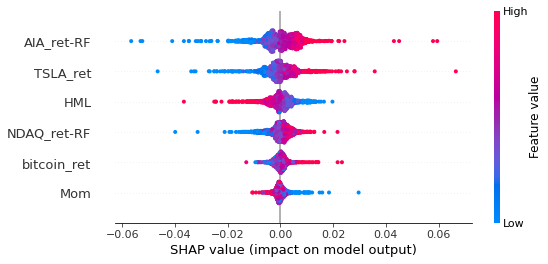

In [538]:
shap.summary_plot(shap_values, X_train)

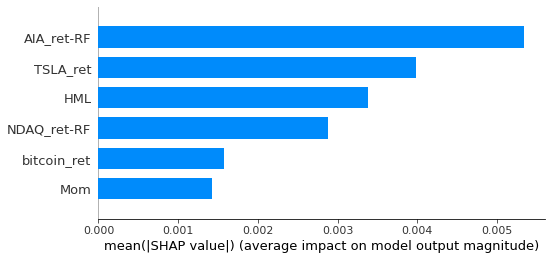

In [556]:
shap.summary_plot(shap_values, X_train, plot_type = "bar")

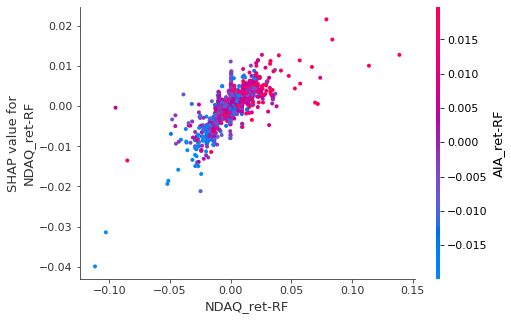

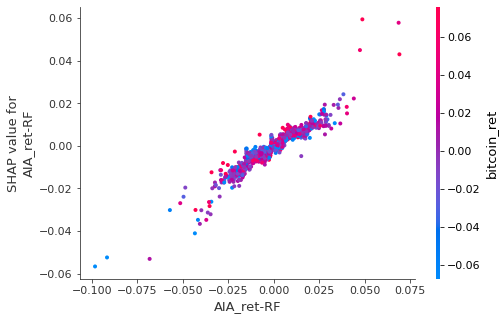

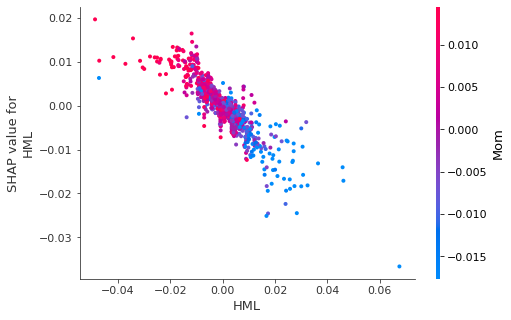

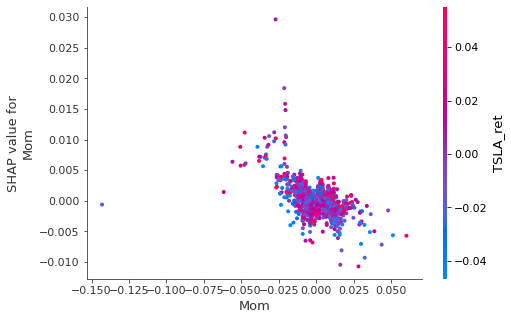

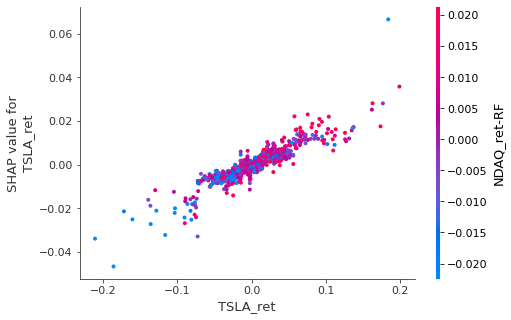

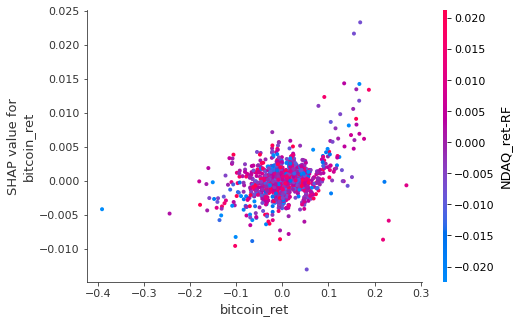

In [571]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_train,interaction_index='auto')

In [552]:
shap.force_plot(explainer.expected_value, shap_values[1,:], X_train.iloc[1,:])

In [578]:
shap.force_plot(explainer.expected_value, shap_values[:500,], X_train[:500])

In [579]:
shap_interaction_values = shap.TreeExplainer(xgb).shap_interaction_values(X_train)


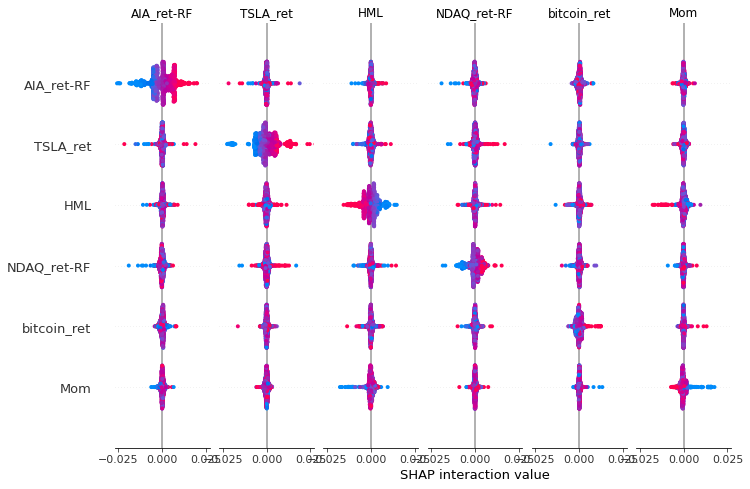

In [580]:
shap.summary_plot(shap_interaction_values, X_train)

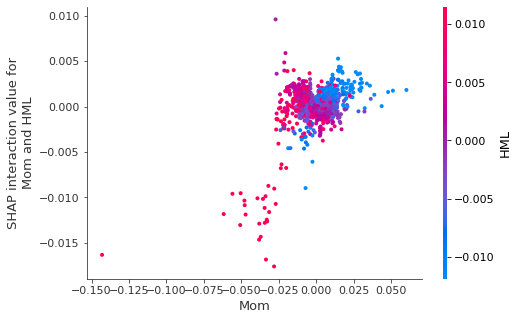

In [581]:
shap.dependence_plot(
    ("Mom", "HML"),
    shap_interaction_values, X_train,
    display_features=X_train
)

## ARKG

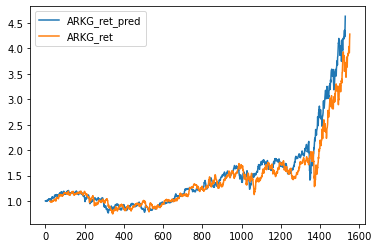

In [582]:
Xs_list = ['NDAQ_ret-RF','HML','Mom','covid']
y_str = "ARKG_ret"

xgb, X_train, y_train = xgboostModel(df, Xs_list, y_str)
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train)

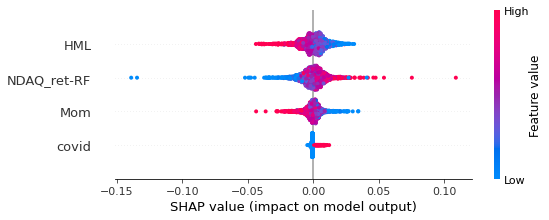

In [583]:
shap.summary_plot(shap_values, X_train)

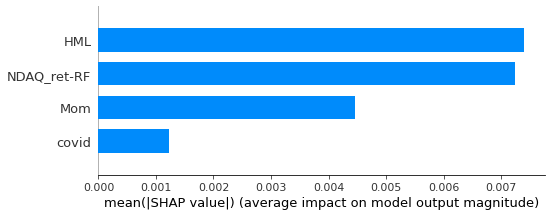

In [584]:
shap.summary_plot(shap_values, X_train, plot_type = "bar")

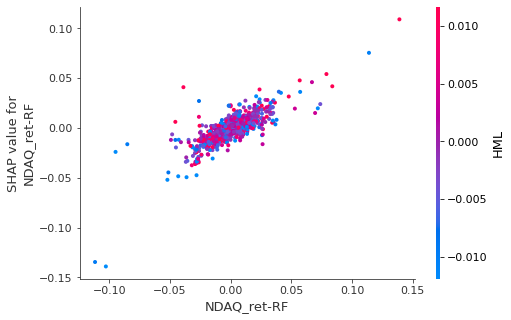

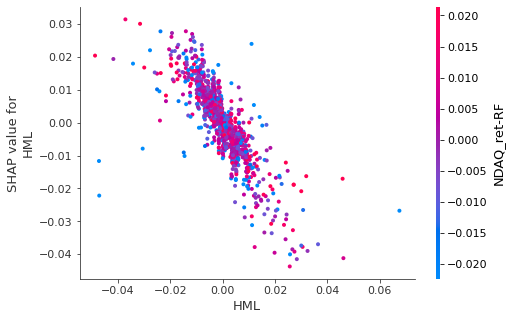

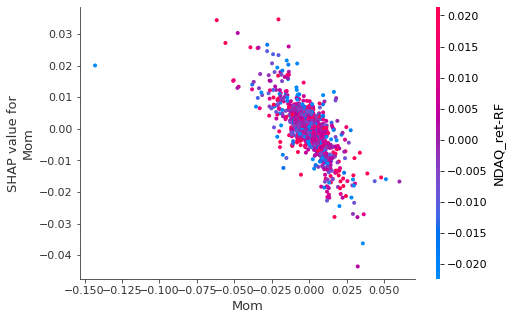

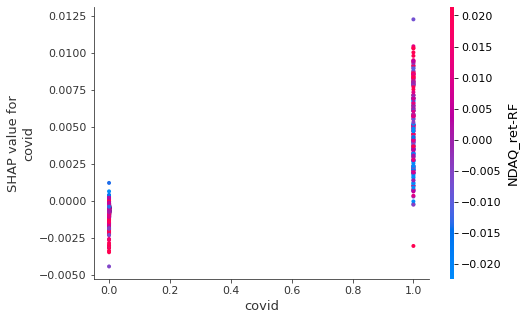

In [587]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_train,interaction_index='auto')

In [588]:
shap.force_plot(explainer.expected_value, shap_values[:500,], X_train[:500])

# Trade Analysis

In [71]:
trade = tabula.read_pdf('ARK_Trades.pdf', pages="all")
first_page = trade[0].iloc[8:,0].str.split(' ', 4, expand=True).iloc[:,0:4]
all_pages = pd.concat([trade[i].iloc[1:,0:4] for i in range(1, len(trade))],axis=0)
first_page.columns = ['date','direction','ticker','price']
all_pages.columns =  ['date','direction','ticker','price']
trade = first_page.append(all_pages)
trade['date'] = pd.to_datetime(trade['date'])
trade.sort_values('date', inplace=True)
trade = trade.drop_duplicates()
trade['direction'] = trade['direction'].map({'Buy':1, 'Sell':-1})
trade['week'] = trade['date'].dt.isocalendar()['week']
trade['month'] = trade['date'].astype(str).str[:7]
trade['price'] = trade['price'].str.replace("[$,]","")
trade = trade[~(trade['price'].str.contains('#'))]
trade['price'] = pd.to_numeric(trade['price'])
trade['price'] = list(map(lambda x: x if x >= 0 else -x, trade['price'].values))

trade_pivot = trade.pivot_table(index='date',
           columns='ticker',
           values='direction',aggfunc=np.sum).fillna(0)

Got stderr: Feb 14, 2021 3:15:26 PM org.apache.pdfbox.pdmodel.encryption.SecurityHandler decryptStream
Feb 14, 2021 3:15:26 PM org.apache.pdfbox.pdmodel.encryption.SecurityHandler decryptStream



<AxesSubplot:xlabel='week'>

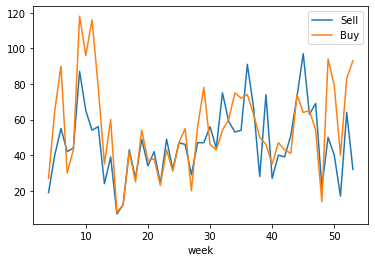

In [57]:
count_by_week = trade[trade['date'] <= "2020-12-31"].\
                    groupby(['week', 'direction'])['ticker'].count().reset_index()
count_by_week = count_by_week.pivot(index='week',
                   columns = 'direction',
                   values = 'ticker')
count_by_week.columns = ['Sell','Buy']
count_by_week.plot()

<AxesSubplot:xlabel='month'>

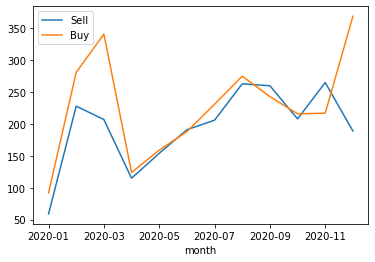

In [58]:
count_by_month = trade[trade['date'] <= "2020-12-31"].\
                    groupby(['month','direction'])['ticker'].count().reset_index()
count_by_month = count_by_month.pivot(index='month',
                   columns = 'direction',
                   values = 'ticker')
count_by_month.columns = ['Sell','Buy']
count_by_month.plot()

In [86]:
trade_subset = trade_pivot[datetime.date(2020,1,1):datetime.date(2020,4,30)]
trade_subset = trade_subset.apply(lambda x: x.value_counts()).T.sort_values(1.0, ascending=False).fillna(0)
num_sell = trade_subset.loc[:,trade_subset.columns < 0].sum(axis=1)
num_buy = trade_subset.loc[:,trade_subset.columns > 0].sum(axis=1)
num_hold = trade_subset[0]
trade_subset = pd.concat([num_sell,num_buy,num_hold],axis=1)
trade_subset.columns= ['num_sell','num_buy','num_hold']
trade_subset.loc[trade_subset['num_buy'] - trade_subset['num_sell'] > 3, 'position'] = "Buy"
trade_subset.loc[trade_subset['num_buy'] - trade_subset['num_sell'] < 3, 'position'] = "Sell"
trade_subset.loc[np.abs(trade_subset['num_buy'] - trade_subset['num_sell']) < 3, 'position'] = "Hold"

In [140]:
summary_output = pd.concat([trade_subset[trade_subset['position']=='Buy'].sort_values('num_buy', ascending=False).head(10),
          trade_subset[trade_subset['position']=='Sell'].sort_values('num_sell', ascending=False).head(10),
          trade_subset[trade_subset['position']=='Hold'].sort_values('num_hold', ascending=True).head(10)])
summary_output.to_csv('Output/positionSummary.csv')

In [126]:
trade_hold = trade[trade['ticker'].isin(trade_subset[trade_subset['position']=='Hold'].sort_values('num_hold').head(10).index.tolist())]\
                    .set_index('date')[datetime.date(2020,1,1):datetime.date(2020,4,30)]\
                    .groupby(['direction','ticker'])['price'].mean().reset_index().sort_values('ticker')\
                    .pivot_table(index='ticker', columns='direction', values='price',aggfunc=np.mean)
trade_hold['pct'] = trade_hold[-1]/trade_hold[1] - 1
trade_hold.sort_values('pct',ascending=False,inplace=True)
#trade_hold.to_csv("Output/2021.02.14 holdPriceSummary.csv")

In [138]:
trade_hold

direction          -1           1       pct
ticker                                     
Z           52.068750   38.479118  0.353169
SPLK       162.370714  122.265500  0.328017
TER         71.635000   60.731000  0.179546
VCYT        24.407500   20.768333  0.175227
ADSK       192.982500  167.422222  0.152670
IOVA        32.540000   28.434286  0.144393
PDD         38.610000   35.600000  0.084551
ILMN       294.774286  290.191538  0.015792
AVAV        55.055882   63.436818 -0.132115
LC           7.292500   11.250000 -0.351778